In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')

import torch
import torch.optim as optim
from torchvision import datasets, transforms


from models.simple_LSTM import *
from models.train_model import train
from models.early_stopping import EarlyStopping

/home/chau/miniconda3/envs/ml_project2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/chau/Desktop/Projects/ml-project-2-ml-sonidito/notebook/../src/models/train_model.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [21]:
# transform=transforms.Compose([
#         transforms.ToTensor(),
#         # transforms.Lambda(lambda x: torch.mean(x, dim=2))
#         transforms.Lambda(lambda x: x.squeeze())
#         ])


# dataset = datasets.MNIST('../data/', download=True, train=True, transform=transform)
# dataset.targets = torch.rand((len(dataset),dataset.data.shape[2])) < 0.9
# size = int(len(dataset) * 0.8)
# train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])

# train_loader = torch.utils.data.DataLoader(train_set, batch_size = 1000)
# val_loader = torch.utils.data.DataLoader(test_set, batch_size = 1000)



In [4]:
from data.dummy import DummyDataset
torch.manual_seed(0)

transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(-262.1078, 31.9126),
        # transforms.Resize([128,128]),
        transforms.Lambda(lambda x : x.squeeze()),
        ])


dataset = DummyDataset('../data/dataset_pickle', transform, max_length=4096)
size = int(len(dataset) * 0.9)

train_set, test_set = torch.utils.data.random_split(dataset, [size, len(dataset)-size])


train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=10)
print(f'train size : {len(train_set)}, val size : {len(test_set)}')

train size : 84, val size : 10


In [9]:
input_size = dataset[0][0].shape[1]
print(f'input_size={input_size}')
hidden_size = 128
num_layers = 1
lr = 1e-3

pos_weight = torch.tensor(12.3162)

model = SimpleLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

early_stopping = EarlyStopping(delta=0.5)

print(model)    


input_size=2
The model has 78,593 trainable parameters
SimpleLSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)


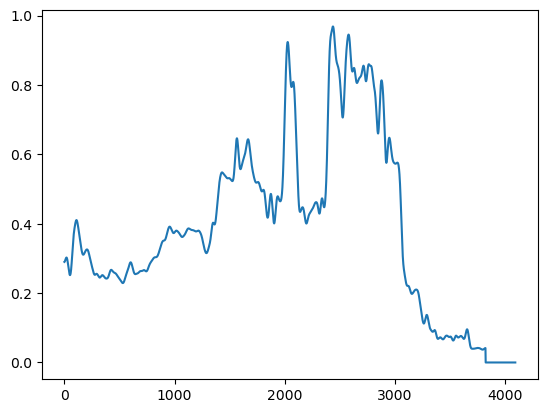

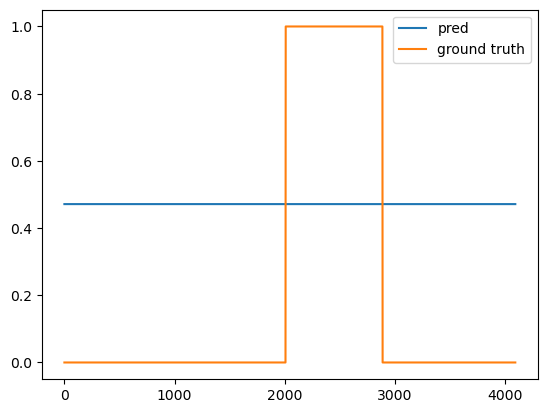

In [24]:
import matplotlib.pyplot as plt

testing_data = test_set[0]
for idx in range(testing_data[0].shape[1]):
    plt.plot(testing_data[0][:, idx])
plt.show()

with torch.no_grad():
    pred = torch.sigmoid(model(testing_data[0]))
    # print(f'Before training : label={testing_data[1]}, pred={pred}')
    plt.plot(pred.detach().numpy(), label='pred')
    plt.plot(testing_data[1], label='ground truth')
    plt.legend()


In [25]:
train(model, 
      train_loader, 
      val_loader, 
      optimizer, 
      criterion, 
      device, 
      n_epochs=5, 
      early_stopping=early_stopping)

KeyboardInterrupt: 

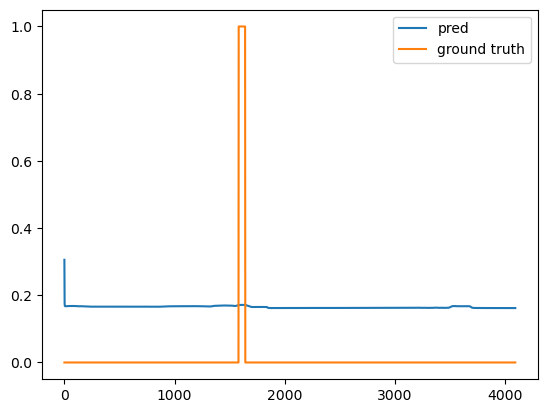

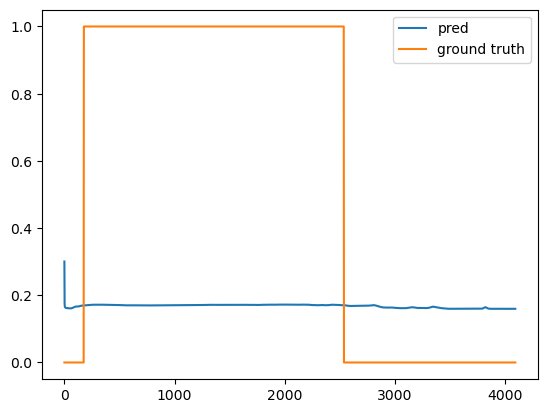

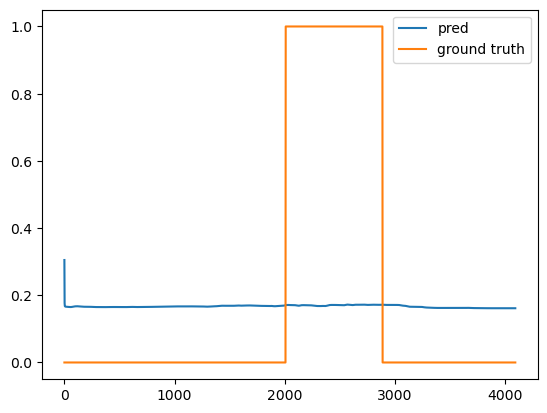

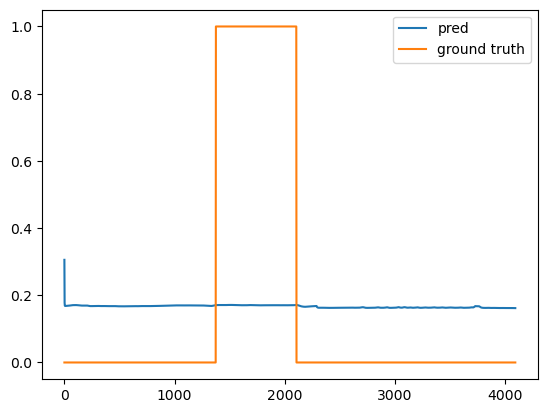

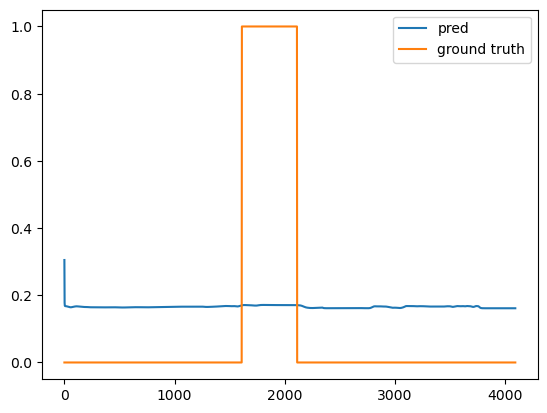

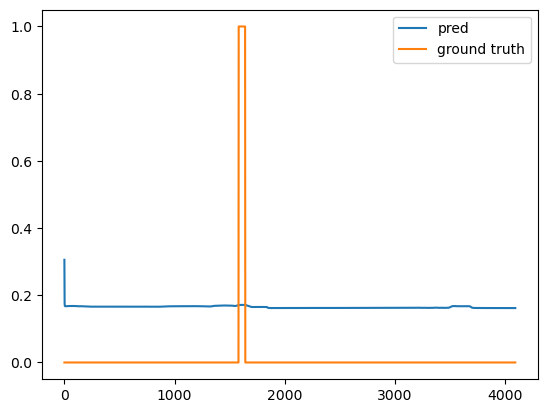

In [ ]:
import numpy as np

model.eval()
with torch.no_grad():
    for idx in np.random.choice(len(test_set), 6): 
        testing_data = test_set[idx]
        pred = torch.sigmoid(model(testing_data[0]))
        plt.plot(pred.detach().numpy(), label='pred')
        plt.plot(testing_data[1], label='ground truth')
        plt.legend()
        plt.show()

SimpleLSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)
pos_weight=74.47272491455078


100%|██████████| 100/100 [04:01<00:00,  2.41s/it, loss=1.38]


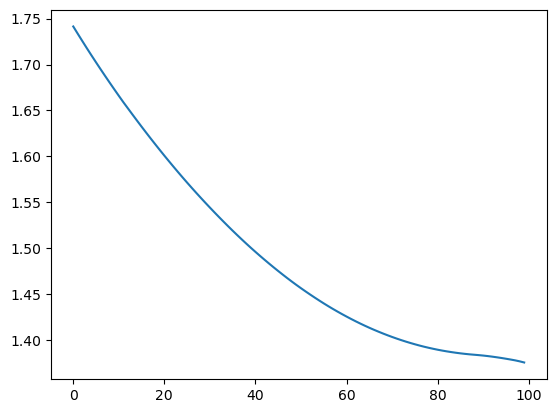

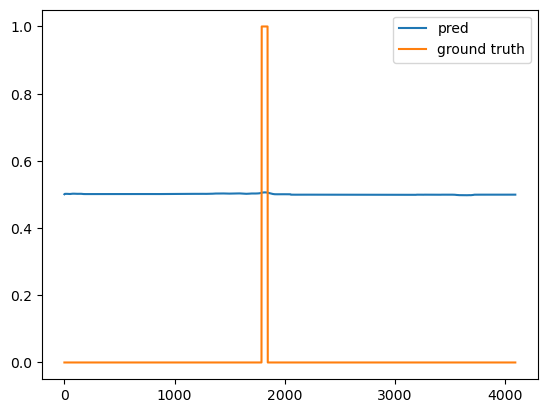

In [19]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

input_size = 2
hidden_size = 128
num_layers = 1
model = SimpleLSTM(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
l1_sigma = 1e-4
print(model)

x, label = dataset[1]

pos_weight = label.size(0) / torch.sum(label)
print(f'pos_weight={pos_weight}')

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

batch_losses = []
with tqdm(range(100)) as tepoch:
    for _ in tepoch:
        model.train()
        pred = model(x)

        loss = criterion(pred, label)
        for param in model.parameters():
            loss = loss + l1_sigma * torch.norm(param, 1)
        batch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=batch_losses[-1])

plt.plot(batch_losses)
plt.show()

model.eval()
with torch.no_grad():    
    pred = torch.sigmoid(model(x))
    plt.plot(pred.detach().numpy(), label='pred')
    plt.plot(label, label='ground truth')
    plt.legend()